# MountainCarContinuous

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import copy
import matplotlib.pyplot as plt 

In [2]:
# Создание среды
env = gym.make("MountainCarContinuous-v0")

# Гиперпараметры
STATE_DIM = env.observation_space.shape[0]  # 2
ACTION_DIM = env.action_space.shape[0]  # 1
ACTOR_LR = 0.0001
CRITIC_LR = 0.001
GAMMA = 0.99
TAU = 0.001
BUFFER_SIZE = 100000
BATCH_SIZE = 64

In [3]:
# Определение Actor
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, action_dim)
        self.tanh = nn.Tanh()

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.tanh(self.fc3(x))

# Определение Critic
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [4]:
# Буфер воспроизведения
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, transition):
        self.buffer.append(transition)
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def size(self):
        return len(self.buffer)
# Ornstein-Uhlenbeck Noise
class OUNoise:
    def __init__(self, size, mu=0.0, theta=0.15, sigma=0.2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

In [5]:
# Создание сетей и оптимизаторов
actor = Actor(STATE_DIM, ACTION_DIM)
critic = Critic(STATE_DIM, ACTION_DIM)
target_actor = Actor(STATE_DIM, ACTION_DIM)
target_critic = Critic(STATE_DIM, ACTION_DIM)

actor_optimizer = optim.Adam(actor.parameters(), lr=ACTOR_LR)
critic_optimizer = optim.Adam(critic.parameters(), lr=CRITIC_LR)

replay_buffer = ReplayBuffer(BUFFER_SIZE)
noise = OUNoise(ACTION_DIM)

# Копирование весов
target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())

# Функция мягкого обновления весов
def soft_update(target, source, tau):
    for target_param, source_param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(tau * source_param.data + (1 - tau) * target_param.data)

In [6]:
# Функция обучения
def train():
    if replay_buffer.size() < BATCH_SIZE:
        return
    batch = replay_buffer.sample(BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*batch)
    
    states = torch.tensor(np.array(states), dtype=torch.float32)
    actions = torch.tensor(np.array(actions), dtype=torch.float32)
    rewards = torch.tensor(np.array(rewards), dtype=torch.float32).unsqueeze(1)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
    dones = torch.tensor(np.array(dones), dtype=torch.float32).unsqueeze(1)
    
    # Обновление Critic
    next_actions = target_actor(next_states)
    target_q = target_critic(next_states, next_actions)
    expected_q = rewards + GAMMA * target_q * (1 - dones)
    current_q = critic(states, actions)
    
    critic_loss = nn.MSELoss()(current_q, expected_q.detach())
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()
    
    # Обновление Actor
    actor_loss = -critic(states, actor(states)).mean()
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()
    
    # Soft update
    soft_update(target_actor, actor, TAU)
    soft_update(target_critic, critic, TAU)

In [7]:
# Запуск обучения
episodes = 200
total_timesteps = 0
reward_history = []
for episode in range(episodes):
    state, _ = env.reset()
    episode_reward = 0
    noise.reset()  # Сброс шума в начале эпизода
    
    for step in range(1000):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action = actor(state_tensor).detach().numpy()[0]
        
        noise_sample = noise.sample()
        action = np.clip(action + noise_sample, env.action_space.low, env.action_space.high)
        
        next_state, reward, done, _, _ = env.step(action)
        replay_buffer.add((state, action, reward, next_state, done))
        train()
        state = next_state
        episode_reward += reward
        total_timesteps += 1
        
        if done:
            break
    
    print(f"Эпизод {episode + 1}, Награда: {episode_reward}")
    reward_history.append(episode_reward)

env.close()

Эпизод 1, Награда: -14.1356903314715
Эпизод 2, Награда: -13.425440297185625
Эпизод 3, Награда: -12.15345550543354
Эпизод 4, Награда: -14.567088865555709
Эпизод 5, Награда: -17.292292690207706
Эпизод 6, Награда: -12.613421611869867
Эпизод 7, Награда: -13.444148817745296
Эпизод 8, Награда: -16.504697031888323
Эпизод 9, Награда: 84.84222096353909
Эпизод 10, Награда: 90.84553678159087
Эпизод 11, Награда: -14.567143310530641
Эпизод 12, Награда: -15.533011537524807
Эпизод 13, Награда: -17.182421081214017
Эпизод 14, Награда: 85.11186492434966
Эпизод 15, Награда: 84.0402371744228
Эпизод 16, Награда: 91.76175563483167
Эпизод 17, Награда: -18.948291823841174
Эпизод 18, Награда: -18.989720067290115
Эпизод 19, Награда: -15.016635399624398
Эпизод 20, Награда: 85.47979120302216
Эпизод 21, Награда: -15.247254509170276
Эпизод 22, Награда: 87.5687088864342
Эпизод 23, Награда: 83.04658921661719
Эпизод 24, Награда: -16.85891209442935
Эпизод 25, Награда: 79.06497161559972
Эпизод 26, Награда: -15.372066017

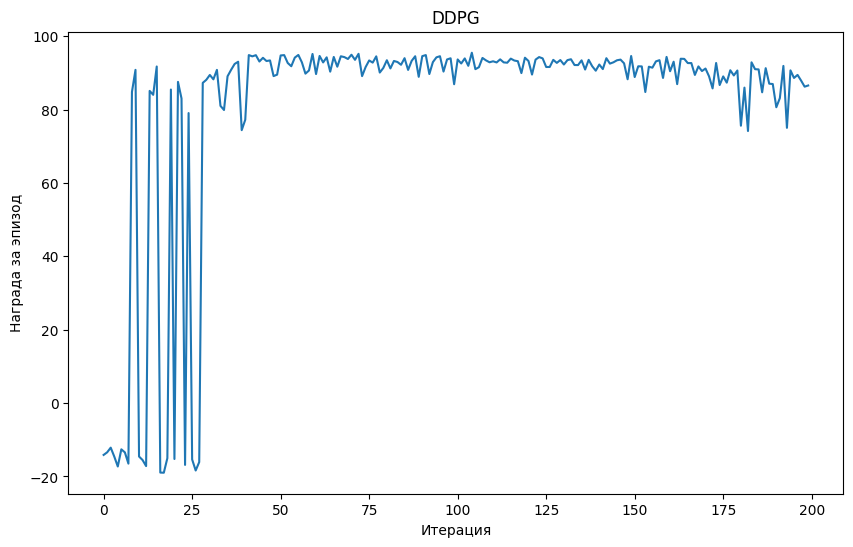

In [13]:
plt.figure(figsize=(10,6))
plt.plot(reward_history)
plt.xlabel("Итерация")
plt.ylabel("Награда за эпизод")
plt.title("DDPG")
plt.savefig("graph")

In [ ]:
# Обучение прошло нормально. модель выучила политику